Code for analyze performance of QFAMES with an illustrative toy model.

In [1]:
import numpy as np
import scipy.linalg as la
from scipy.stats import truncnorm
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsfonts, amssymb, amsmath, physics}')
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['font.size'] = 12

import data_generator
import QFAMES

In [2]:
def generate_ts_distribution(T,N,sigma):
    """ Generate time samples from truncated Gaussian
    Input:

    T : variance of Gaussian
    sigma : truncated parameter
    N : number of samples

    Output:

    t_list: np.array of time points
    """
    np.random.seed(42)  #
    t_list=truncnorm.rvs(-sigma, sigma, loc=0, scale=T, size=N)
    return t_list

def generate_Z(spectrum,coefficient,T,N,sigma):
    """ Generate Z samples for a given T,N,sigma
    Input:

    spectrum: np.array of eigenvalues
    coefficient: np.array of overlap
    T : variance of Gaussian
    N : number of time samples
    sigma : truncated parameter

    Output:

    Z_est: np.array of Z output
    t_list: np.array of time points
    T_max: maximal running time
    T_total: total running time
    """
    t_list = generate_ts_distribution(T,N,sigma)
    N_list = np.ones(len(t_list))
    T_max = max(np.abs(t_list))
    T_total = sum(np.multiply(np.abs(t_list),N_list))
    Z_est, _ , _ =data_generator.generate_Hadamard_test_data(spectrum,coefficient,t_list,N_list)
    return Z_est, t_list, T_max, T_total

# Test QFAMES

In [3]:
# Toy model spectrum
spectrum = np.array([0., 0., 0.1])

# Initial states
L=R=3
overlap=np.array([[1.,1.,1.],[1.,-1.,1.],[1.,1.,-1.]]) / np.sqrt(3)

# QFAMES parameters
N_rep=1
T_max=40
N=2000
K_QFAMES=2
alpha=5
sigma=1 #sigma is the truncation parameter
tau=0.1*np.sqrt(L*R)
Z_est=np.zeros((L,R,N),dtype='complex')

for n in range(N_rep):
    print('Running iteration',n+1,'of',N_rep)
    d_x=1*0.005/T_max
    num_x=int(1/(d_x*2))
    x_rough=np.arange(0,num_x)*d_x*2-0.5
    G_est=np.zeros((L,R,len(x_rough)),dtype='complex')
    for l in range(L):
        for r in range(R):
            Z_est[l,r,:],t_list, _, T_total = generate_Z(spectrum,overlap[l,:]*overlap[r,:],T_max,N,sigma)
    for l in range(L):
        for r in range(R):
            G_est[l, r, :] = Z_est[l, r, :].dot(np.exp(1j*np.outer(t_list,x_rough)))/N
            
    output_energy, output_num, output_vector= QFAMES.QFAMES(Z_est, d_x, t_list, K_QFAMES, alpha, T_max, tau, 'True')
    indices_to_delete = np.where(output_num<1)[0] #delete the noise part
    output_energy = np.delete(output_energy, indices_to_delete, axis=None)
    output_num = np.delete(output_num, indices_to_delete, axis=None)
    if n==0:
        print('Output of QFAMES energy=',output_energy)
        print('Output of QFAMES number=',output_num)

Running iteration 1 of 1
Output of QFAMES energy= [0.00140735+0.j 0.10253235+0.j]
Output of QFAMES number= [2 1]


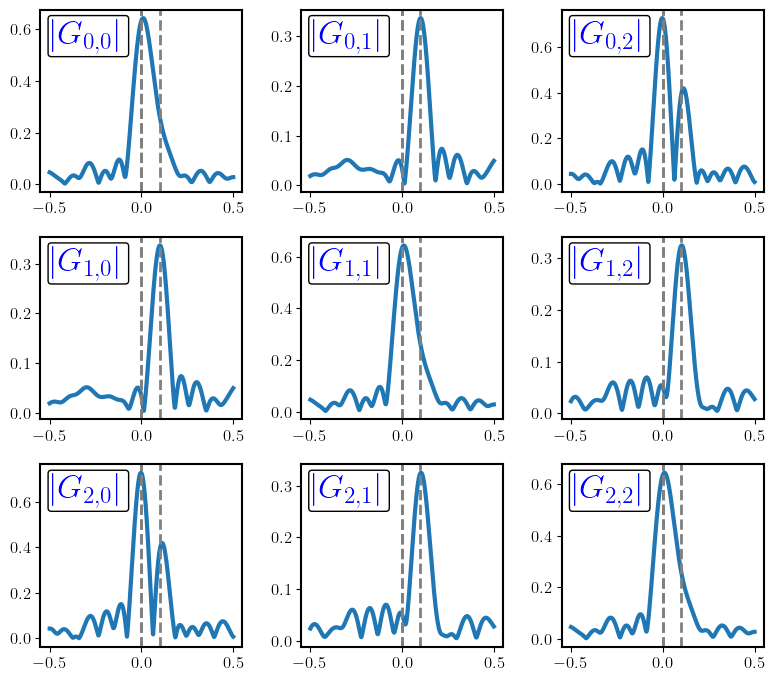

In [4]:
# Plot matrix elements of G
fig, axes = plt.subplots(3, 3, figsize=(8, 7))
for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        ax.plot(x_rough, np.abs(G_est[i,j,:]),linewidth=3)
        # Add vertical dashed lines indicating eigenvalues
        for idx in range(3):
            ax.axvline(spectrum[idx], color='gray', linestyle='--', linewidth=2)
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.5)

        label = r'$|G_{%d,%d}|$' % (i, j)
        ax.text(0.42, 0.95, label, transform=ax.transAxes,
        fontsize=24, color='blue', ha='right', va='top',
        bbox=dict(boxstyle='round,pad=0.1',
                    facecolor='white',
                    edgecolor='black')
                    )
plt.tight_layout()
plt.savefig('figs/G_elements.pdf', bbox_inches='tight')
plt.show()
plt.close()

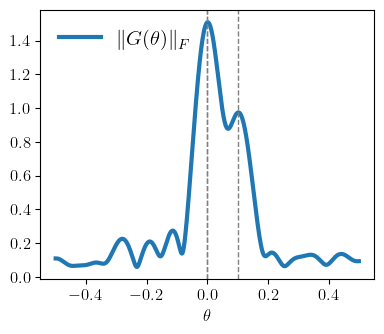

In [5]:
# Plot the Frobenius norm of G matrix
G_total = np.sqrt(np.sum(np.abs(G_est)**2, axis=(0, 1)))
plt.figure(figsize=(4, 3.5))
plt.plot(x_rough, G_total, linewidth=3, label = r'$\|G(\theta)\|_F$')
for idx in range(3):
    plt.axvline(spectrum[idx], color='gray', linestyle='--', linewidth=1)
plt.xlabel(r'$\theta$')
plt.legend(fontsize=15, frameon=False)
plt.tight_layout()
plt.savefig('figs/Frobenius.pdf', bbox_inches='tight')
plt.show()
plt.close()

/var/folders/st/7qh3h6rn7_l15r_yp4t6vz0c0000gn/T/ipykernel_82519/440317769.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  G_opt[l, r, m] = Z_est[l, r, :].dot(np.exp(1j*np.outer(t_list,output_energy[m])))/N


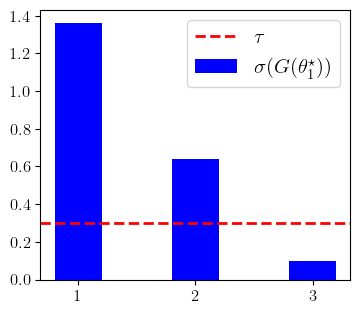

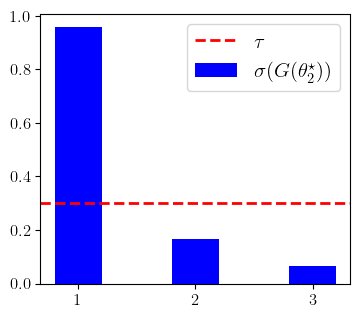

In [6]:
G_opt = np.zeros((L, R, 2), dtype='complex')
S_list = np.zeros((2, R))
#Draw singular value graph
for m in range (2):
    for l in range(L):
        for r in range(R):
            G_opt[l, r, m] = Z_est[l, r, :].dot(np.exp(1j*np.outer(t_list,output_energy[m])))/N
    U, S, V = np.linalg.svd(G_opt[:, :, m], full_matrices=False)
    S_list[m, :] = S

plt.figure(figsize=(4, 3.5))
x = np.arange(len(S_list[0, :]))
plt.axhline(0.1*np.sqrt(L*R), color='red', linestyle='--', linewidth=2, label=r'$\tau$')
plt.bar(x+1, S_list[0, :], label=r'$\sigma(G(\theta^\star_1))$', color='blue', width=0.4)
plt.xticks(x+1, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
plt.savefig('figs/Singular_1.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(4, 3.5))
x = np.arange(len(S_list[1, :]))
plt.axhline(0.1*np.sqrt(L*R), color='red', linestyle='--', linewidth=2, label=r'$\tau$')
plt.bar(x+1, S_list[1, :], label=r'$\sigma(G(\theta^\star_2))$', color='blue', width=0.4)
plt.xticks(x+1, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
plt.savefig('figs/Singular_2.pdf', bbox_inches='tight')
plt.show()
